In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import joblib

# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
sns.set(style="whitegrid")


In [2]:
df = pd.read_csv(r"C:\Users\eshra\heart-disease-prediction\data\framingham.csv")  # adjust path if needed
df.head()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
df.info()
df.describe().T
df.isnull().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


glucose            388
education          105
BPMeds              53
totChol             50
cigsPerDay          29
BMI                 19
heartRate            1
male                 0
age                  0
currentSmoker        0
prevalentStroke      0
prevalentHyp         0
diabetes             0
sysBP                0
diaBP                0
TenYearCHD           0
dtype: int64

In [4]:
# Target:
TARGET = 'TenYearCHD'

# Features to use (must match the app input order)
FEATURES = [
    'age',         # numeric
    'male',        # 1=male, 0=female
    'currentSmoker', # 1/0
    'cigsPerDay',
    'totChol',
    'sysBP',
    'diaBP',
    'BMI',
    'heartRate',
    'glucose',
    'diabetes',    # 1/0
    'prevalentHyp' # prevalent hypertension (1/0)
]

# check they exist
missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing:
    raise ValueError("Missing columns in CSV: " + ", ".join(missing))

df = df[FEATURES + [TARGET]]
df.head()


,age,male,currentSmoker,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,diabetes,prevalentHyp,TenYearCHD
0,39,1,0,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0,0,0
1,46,0,0,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0,0,0
2,48,1,1,20.0,245.0,127.5,80.0,25.34,75.0,70.0,0,0,0
3,61,0,1,30.0,225.0,150.0,95.0,28.58,65.0,103.0,0,1,1
4,46,0,1,23.0,285.0,130.0,84.0,23.10,85.0,85.0,0,0,0


In [5]:
# Option 1: drop rows with NaN (simple)
df_clean = df.dropna().reset_index(drop=True)
print("Rows after dropna:", len(df_clean))

# Option 2 (alternative): impute median (uncomment to use)
# df_clean = df.copy()
# for c in FEATURES:
#     df_clean[c].fillna(df_clean[c].median(), inplace=True)
# df_clean[TARGET].fillna(df_clean[TARGET].mode()[0], inplace=True)


Rows after dropna: 3802


TenYearCHD
0    0.84666
1    0.15334
Name: proportion, dtype: float64


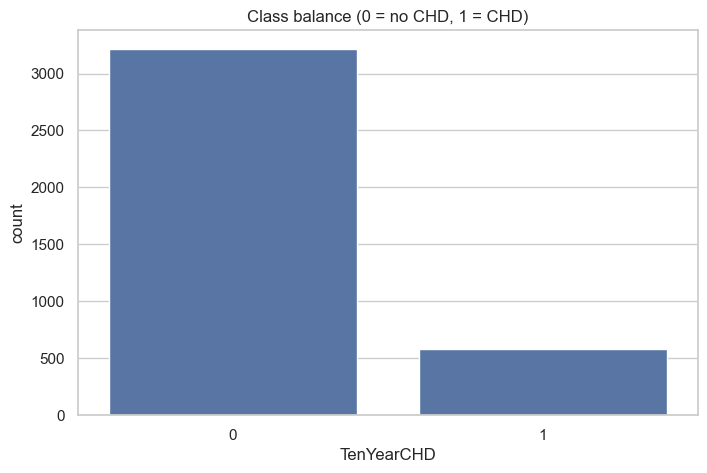

In [6]:
print(df_clean[TARGET].value_counts(normalize=True))
sns.countplot(x=TARGET, data=df_clean)
plt.title("Class balance (0 = no CHD, 1 = CHD)")
plt.show()


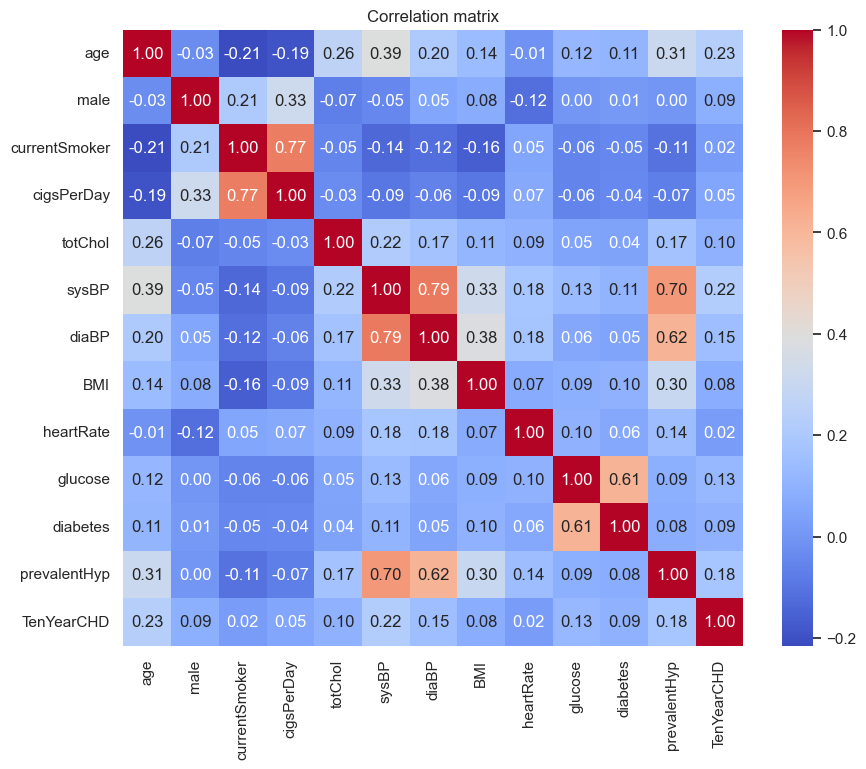

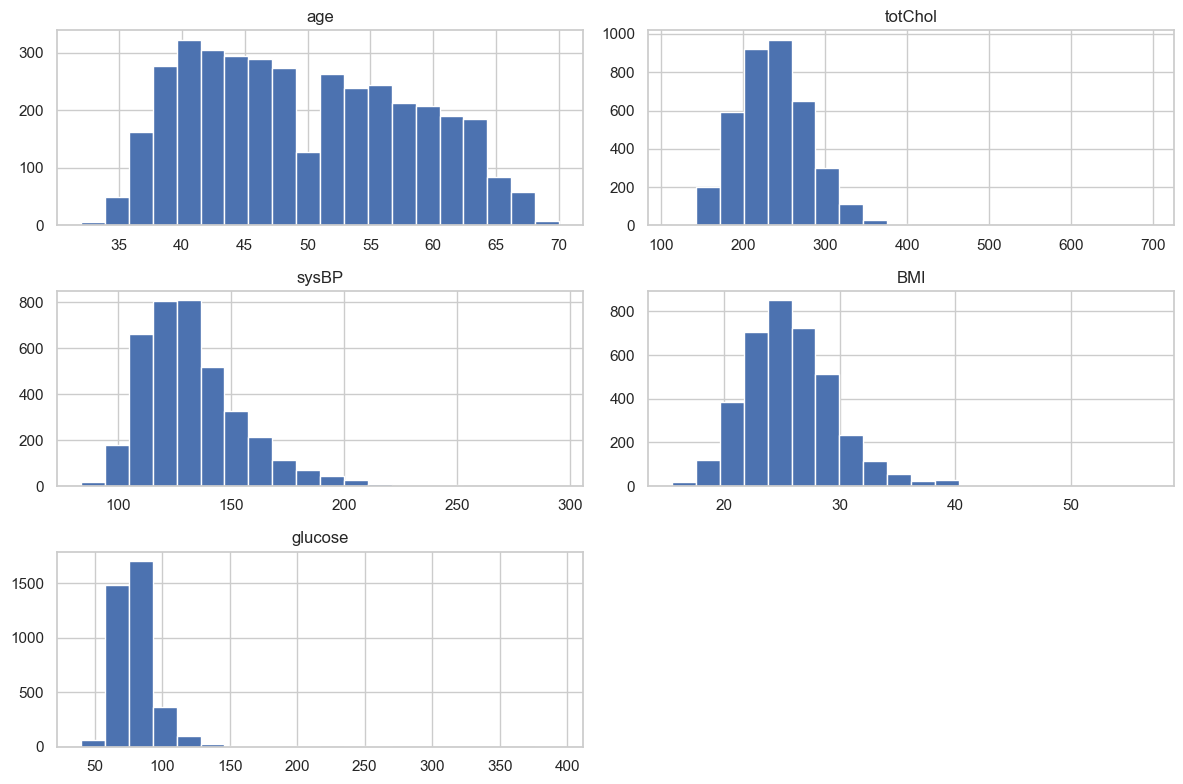

In [7]:
corr = df_clean.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

# histograms for some features
df_clean[['age','totChol','sysBP','BMI','glucose']].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()


In [8]:
X = df_clean[FEATURES].values
y = df_clean[TARGET].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y)
print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (2661, 12) (1141, 12)


In [9]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.8492550394390885
Precision: 0.5555555555555556
Recall: 0.08571428571428572
F1-score: 0.1485148514851485
ROC-AUC: 0.7049571132800947

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       966
           1       0.56      0.09      0.15       175

    accuracy                           0.85      1141
   macro avg       0.71      0.54      0.53      1141
weighted avg       0.81      0.85      0.80      1141



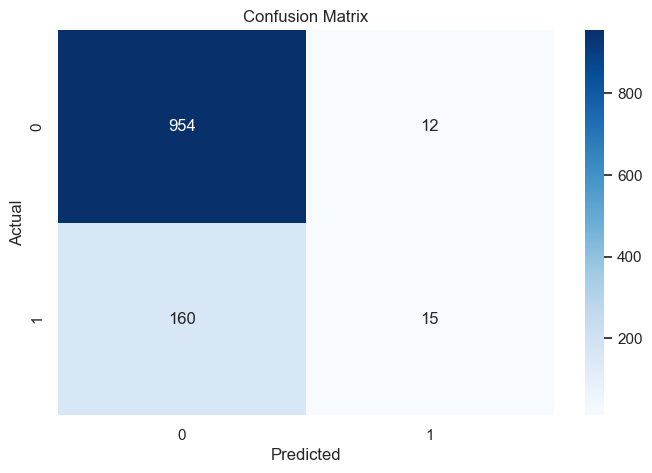

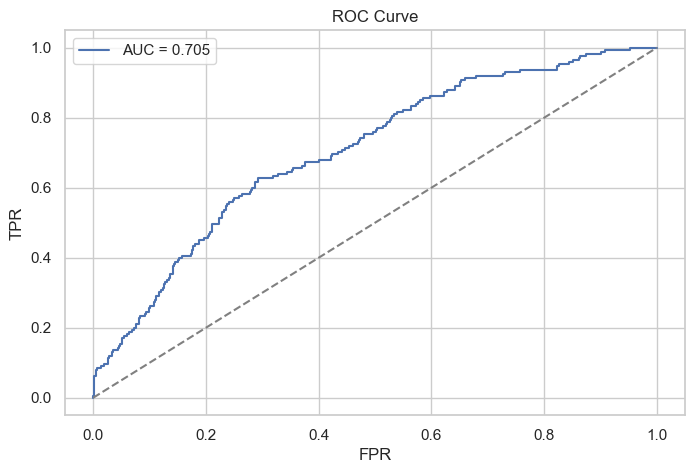

In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("ROC-AUC:", auc)
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, th = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [11]:
os.makedirs("../model", exist_ok=True)
joblib.dump(model, "../model/logistic_model.pkl")
joblib.dump(scaler, "../model/scaler.pkl")
print("Saved model and scaler to ../model/")


Saved model and scaler to ../model/


In [12]:
import os

if os.path.exists("../model/logistic_model.pkl") and os.path.exists("../model/scaler.pkl"):
    print("✅ Model and Scaler saved correctly!")
else:
    print("❌ Files missing, re-run training script.")


✅ Model and Scaler saved correctly!
